In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [6]:
import data_setup

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x27a22d298c8>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x27a22d34188>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [9]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [10]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [14]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828


 20%|██        | 1/5 [01:19<05:16, 79.04s/it]

Epoch: 2 | train_loss: 0.9204 | train_acc: 0.6445 | test_loss: 0.8134 | test_acc: 0.7746


 40%|████      | 2/5 [02:34<03:50, 76.93s/it]

Epoch: 3 | train_loss: 0.7602 | train_acc: 0.8750 | test_loss: 0.6562 | test_acc: 0.8864


 60%|██████    | 3/5 [03:48<02:31, 75.76s/it]

Epoch: 4 | train_loss: 0.6868 | train_acc: 0.7695 | test_loss: 0.6201 | test_acc: 0.8759


 80%|████████  | 4/5 [05:01<01:14, 74.70s/it]

Epoch: 5 | train_loss: 0.6467 | train_acc: 0.7969 | test_loss: 0.6054 | test_acc: 0.8665


100%|██████████| 5/5 [06:16<00:00, 75.25s/it]


In [15]:
results

{'train_loss': [1.0965989381074905,
  0.9203867614269257,
  0.7602226957678795,
  0.6868081353604794,
  0.6466988027095795],
 'train_acc': [0.38671875, 0.64453125, 0.875, 0.76953125, 0.796875],
 'test_loss': [0.8842612504959106,
  0.8134126861890157,
  0.6561942299207052,
  0.6200585762659708,
  0.605372945467631],
 'test_acc': [0.6827651515151515,
  0.774621212121212,
  0.8863636363636364,
  0.8759469696969697,
  0.8664772727272728]}

In [16]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [17]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_10_percent\effnetb0\5_epochs...


In [18]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [19]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [20]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [21]:
simple_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [22]:
BATCH_SIZE = 32

train_dir_10_percent = Path("data/pizza_steak_sushi/train/")
train_dir_20_percent = Path("data/pizza_steak_sushi_20_percent/train/")

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [24]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [25]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [26]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [27]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [28]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [29]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_10_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [01:13<04:53, 73.48s/it]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782


 40%|████      | 2/5 [02:23<03:33, 71.15s/it]

Epoch: 2 | train_loss: 0.9304 | train_acc: 0.5547 | test_loss: 0.7984 | test_acc: 0.6932


 60%|██████    | 3/5 [03:20<02:09, 64.98s/it]

Epoch: 3 | train_loss: 0.8171 | train_acc: 0.6953 | test_loss: 0.6695 | test_acc: 0.8759


 80%|████████  | 4/5 [04:20<01:02, 62.82s/it]

Epoch: 4 | train_loss: 0.7350 | train_acc: 0.7617 | test_loss: 0.6444 | test_acc: 0.8864


100%|██████████| 5/5 [05:19<00:00, 63.90s/it]

Epoch: 5 | train_loss: 0.6784 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.9072
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_10_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [01:09<04:39, 69.86s/it]

Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9453 | test_acc: 0.7102


 40%|████      | 2/5 [02:35<03:57, 79.30s/it]

Epoch: 2 | train_loss: 0.8765 | train_acc: 0.7969 | test_loss: 0.8987 | test_acc: 0.7225


 60%|██████    | 3/5 [03:58<02:41, 80.74s/it]

Epoch: 3 | train_loss: 0.8104 | train_acc: 0.6992 | test_loss: 0.8249 | test_acc: 0.8352


 80%|████████  | 4/5 [05:21<01:21, 81.82s/it]

Epoch: 4 | train_loss: 0.6903 | train_acc: 0.9141 | test_loss: 0.7453 | test_acc: 0.8665


100%|██████████| 5/5 [06:44<00:00, 80.84s/it]

Epoch: 5 | train_loss: 0.6074 | train_acc: 0.8984 | test_loss: 0.6994 | test_acc: 0.8665
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------



[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_10_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [01:08<10:15, 68.43s/it]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782


 20%|██        | 2/10 [02:20<09:23, 70.41s/it]

Epoch: 2 | train_loss: 0.9304 | train_acc: 0.5547 | test_loss: 0.7984 | test_acc: 0.6932


 30%|███       | 3/10 [03:33<08:21, 71.62s/it]

Epoch: 3 | train_loss: 0.8171 | train_acc: 0.6953 | test_loss: 0.6695 | test_acc: 0.8759


 40%|████      | 4/10 [04:50<07:23, 73.90s/it]

Epoch: 4 | train_loss: 0.7350 | train_acc: 0.7617 | test_loss: 0.6444 | test_acc: 0.8864


 50%|█████     | 5/10 [06:07<06:14, 74.90s/it]

Epoch: 5 | train_loss: 0.6784 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.9072


 60%|██████    | 6/10 [07:15<04:50, 72.60s/it]

Epoch: 6 | train_loss: 0.5871 | train_acc: 0.7891 | test_loss: 0.5834 | test_acc: 0.8968


 70%|███████   | 7/10 [08:27<03:37, 72.57s/it]

Epoch: 7 | train_loss: 0.6183 | train_acc: 0.7891 | test_loss: 0.5444 | test_acc: 0.8864


 80%|████████  | 8/10 [09:40<02:25, 72.54s/it]

Epoch: 8 | train_loss: 0.5403 | train_acc: 0.8008 | test_loss: 0.4768 | test_acc: 0.8968


 90%|█████████ | 9/10 [10:58<01:14, 74.32s/it]

Epoch: 9 | train_loss: 0.4885 | train_acc: 0.8008 | test_loss: 0.4707 | test_acc: 0.9176


100%|██████████| 10/10 [12:06<00:00, 72.61s/it]

Epoch: 10 | train_loss: 0.5147 | train_acc: 0.8086 | test_loss: 0.5353 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_10_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [01:22<12:22, 82.45s/it]

Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9453 | test_acc: 0.7102


 20%|██        | 2/10 [02:48<11:18, 84.79s/it]

Epoch: 2 | train_loss: 0.8765 | train_acc: 0.7969 | test_loss: 0.8987 | test_acc: 0.7225


 30%|███       | 3/10 [04:23<10:24, 89.23s/it]

Epoch: 3 | train_loss: 0.8104 | train_acc: 0.6992 | test_loss: 0.8249 | test_acc: 0.8352


 40%|████      | 4/10 [05:57<09:05, 90.96s/it]

Epoch: 4 | train_loss: 0.6903 | train_acc: 0.9141 | test_loss: 0.7453 | test_acc: 0.8665


 50%|█████     | 5/10 [07:29<07:37, 91.58s/it]

Epoch: 5 | train_loss: 0.6074 | train_acc: 0.8984 | test_loss: 0.6994 | test_acc: 0.8665


 60%|██████    | 6/10 [08:57<06:01, 90.36s/it]

Epoch: 6 | train_loss: 0.6273 | train_acc: 0.8047 | test_loss: 0.6431 | test_acc: 0.8570


 70%|███████   | 7/10 [10:26<04:29, 90.00s/it]

Epoch: 7 | train_loss: 0.5653 | train_acc: 0.8086 | test_loss: 0.6133 | test_acc: 0.8769


 80%|████████  | 8/10 [12:00<03:02, 91.10s/it]

Epoch: 8 | train_loss: 0.4832 | train_acc: 0.9570 | test_loss: 0.5715 | test_acc: 0.8873


 90%|█████████ | 9/10 [13:22<01:28, 88.27s/it]

Epoch: 9 | train_loss: 0.4804 | train_acc: 0.9336 | test_loss: 0.5821 | test_acc: 0.8769


100%|██████████| 10/10 [14:47<00:00, 88.73s/it]

Epoch: 10 | train_loss: 0.4091 | train_acc: 0.9492 | test_loss: 0.5398 | test_acc: 0.8769
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_20_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [01:20<05:22, 80.59s/it]

Epoch: 1 | train_loss: 0.9652 | train_acc: 0.5625 | test_loss: 0.6631 | test_acc: 0.8655


 40%|████      | 2/5 [02:37<03:55, 78.43s/it]

Epoch: 2 | train_loss: 0.7174 | train_acc: 0.8146 | test_loss: 0.5644 | test_acc: 0.9280


 60%|██████    | 3/5 [03:57<02:38, 79.02s/it]

Epoch: 3 | train_loss: 0.5389 | train_acc: 0.8750 | test_loss: 0.4747 | test_acc: 0.9176


 80%|████████  | 4/5 [05:15<01:18, 78.69s/it]

Epoch: 4 | train_loss: 0.4867 | train_acc: 0.8604 | test_loss: 0.4555 | test_acc: 0.8873


100%|██████████| 5/5 [06:34<00:00, 78.86s/it]

Epoch: 5 | train_loss: 0.4350 | train_acc: 0.8896 | test_loss: 0.3677 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_20_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [02:03<08:14, 123.72s/it]

Epoch: 1 | train_loss: 0.9892 | train_acc: 0.5292 | test_loss: 0.7963 | test_acc: 0.8049


 40%|████      | 2/5 [04:07<06:10, 123.47s/it]

Epoch: 2 | train_loss: 0.7758 | train_acc: 0.7479 | test_loss: 0.6622 | test_acc: 0.8561


 60%|██████    | 3/5 [06:16<04:12, 126.17s/it]

Epoch: 3 | train_loss: 0.6133 | train_acc: 0.8333 | test_loss: 0.5939 | test_acc: 0.8873


 80%|████████  | 4/5 [08:16<02:03, 123.68s/it]

Epoch: 4 | train_loss: 0.4921 | train_acc: 0.8854 | test_loss: 0.5245 | test_acc: 0.9384


100%|██████████| 5/5 [10:18<00:00, 123.74s/it]

Epoch: 5 | train_loss: 0.4525 | train_acc: 0.8979 | test_loss: 0.4748 | test_acc: 0.9384
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_20_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [01:34<14:08, 94.23s/it]

Epoch: 1 | train_loss: 0.9652 | train_acc: 0.5625 | test_loss: 0.6631 | test_acc: 0.8655


 20%|██        | 2/10 [03:13<12:58, 97.30s/it]

Epoch: 2 | train_loss: 0.7174 | train_acc: 0.8146 | test_loss: 0.5644 | test_acc: 0.9280


 30%|███       | 3/10 [04:53<11:28, 98.31s/it]

Epoch: 3 | train_loss: 0.5389 | train_acc: 0.8750 | test_loss: 0.4747 | test_acc: 0.9176


 40%|████      | 4/10 [06:30<09:47, 97.88s/it]

Epoch: 4 | train_loss: 0.4867 | train_acc: 0.8604 | test_loss: 0.4555 | test_acc: 0.8873


 50%|█████     | 5/10 [08:11<08:14, 98.95s/it]

Epoch: 5 | train_loss: 0.4350 | train_acc: 0.8896 | test_loss: 0.3677 | test_acc: 0.9384


 60%|██████    | 6/10 [09:44<06:27, 96.92s/it]

Epoch: 6 | train_loss: 0.3611 | train_acc: 0.9292 | test_loss: 0.3761 | test_acc: 0.8873


 70%|███████   | 7/10 [11:16<04:46, 95.55s/it]

Epoch: 7 | train_loss: 0.3367 | train_acc: 0.9000 | test_loss: 0.3204 | test_acc: 0.9280


 80%|████████  | 8/10 [12:51<03:10, 95.28s/it]

Epoch: 8 | train_loss: 0.3353 | train_acc: 0.9146 | test_loss: 0.2849 | test_acc: 0.9280


 90%|█████████ | 9/10 [14:21<01:33, 93.59s/it]

Epoch: 9 | train_loss: 0.3535 | train_acc: 0.8979 | test_loss: 0.2876 | test_acc: 0.9384


100%|██████████| 10/10 [15:56<00:00, 95.61s/it]

Epoch: 10 | train_loss: 0.3366 | train_acc: 0.9021 | test_loss: 0.2915 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-12-29\data_20_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [02:04<18:39, 124.39s/it]

Epoch: 1 | train_loss: 0.9892 | train_acc: 0.5292 | test_loss: 0.7963 | test_acc: 0.8049


 20%|██        | 2/10 [04:00<15:56, 119.60s/it]

Epoch: 2 | train_loss: 0.7758 | train_acc: 0.7479 | test_loss: 0.6622 | test_acc: 0.8561


 30%|███       | 3/10 [05:42<13:00, 111.54s/it]

Epoch: 3 | train_loss: 0.6133 | train_acc: 0.8333 | test_loss: 0.5939 | test_acc: 0.8873


 40%|████      | 4/10 [07:14<10:22, 103.79s/it]

Epoch: 4 | train_loss: 0.4921 | train_acc: 0.8854 | test_loss: 0.5245 | test_acc: 0.9384


 50%|█████     | 5/10 [08:45<08:16, 99.28s/it] 

Epoch: 5 | train_loss: 0.4525 | train_acc: 0.8979 | test_loss: 0.4748 | test_acc: 0.9384


 60%|██████    | 6/10 [10:19<06:29, 97.40s/it]

Epoch: 6 | train_loss: 0.4256 | train_acc: 0.8729 | test_loss: 0.4484 | test_acc: 0.9176


 70%|███████   | 7/10 [11:54<04:49, 96.48s/it]

Epoch: 7 | train_loss: 0.4224 | train_acc: 0.8500 | test_loss: 0.4415 | test_acc: 0.9280


 80%|████████  | 8/10 [13:25<03:09, 94.99s/it]

Epoch: 8 | train_loss: 0.3829 | train_acc: 0.8500 | test_loss: 0.3926 | test_acc: 0.9384


 90%|█████████ | 9/10 [15:07<01:37, 97.09s/it]

Epoch: 9 | train_loss: 0.3087 | train_acc: 0.9417 | test_loss: 0.4678 | test_acc: 0.8674


100%|██████████| 10/10 [16:59<00:00, 101.96s/it]

Epoch: 10 | train_loss: 0.3673 | train_acc: 0.9104 | test_loss: 0.3912 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

Wall time: 1h 28min 50s


In [30]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

In [31]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

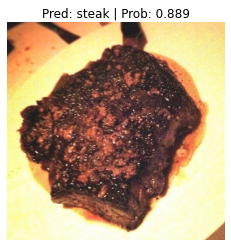

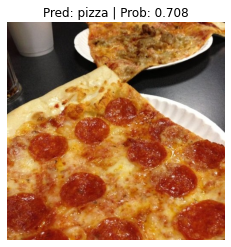

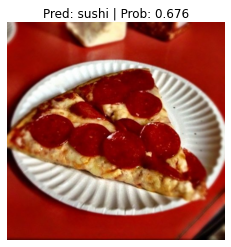

In [32]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

data\04-pizza-dad.jpeg already exists, skipping download.


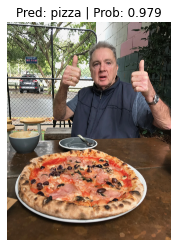

In [33]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)